# Mini-project 20 report from Group 6

Group members:
    1. Nguyen Duy Hung - 20194436
    2. Hoang Thien Tam - 20194450
    3. Tran Quoc Lap - 20194443

## I. Introduction

The development of modern society requires the increase in workload. Nowadays, we witness the inevitability of teamwork on large projects. In that context, it is essential to divide the work balancely between people and people. However, this is not an easy problem with human as it requires time, energy and intelligence. But we can take advantage of computer - the machine that work tirelessly.

Based on the knowledge attained from the course Fundamental of Optimization, we introduce the Balanced Article Assignment problem and it mathematical model. Then, we propose methods for solving this problem including Ortools using MIP solver, Heuristics, Backtracking, and a special method that we call it X-algorithm.

The Balanced Article Assignment problem:
> There are $N$ articles $1, 2,…, N$ need assigning to $M$ scientists $1, 2, …, M$ for commenting.
>
> Each article $i$ can only be given to a certain list of scientists $L(i)$ who have the expertise to comment on the article. Every article must be given to at least $K$ scientists in order to guarantee reliability. 
>
> Find a way of assigning so that the maximum of scientists' workload is minimized.

The report is organized as follows:
* Section 1: Present the context and objective of the work.
* Section 2: Present the problem formulation under an integer linear programming model. 
* Section 3: Present the methods for solving this problem.
* Section 4: Present experimental results with several data sets of different sizes and give some analysis.
* Section 5: Summarize the objective of the work, results obtained.

## II. Problem formulation

### 2.1. Definitions and notations



### 2.2. Integer linear programming model
    
#### 2.2.1. Variables:
> `N`: the number of articles.
>
> `M`: the number of scientists.
>
> `K`: the least number of scientists needed to work on an article.
>
> `A`: nested array where `A[i]` contains the list of scientists who can take on $i$. E.g:
>> ```
[[1, 2, 4, 6, 7], 
[1, 2, 3, 4, 5, 7], 
[1, 2, 6, 7], 
[1, 2, 4, 5, 7], 
[1, 2, 3, 6, 7], 
[1, 3, 4, 5, 6], 
[1, 2, 6], 
[2, 4, 5, 7], 
[1, 3, 4, 5], 
[1, 2, 3, 4, 5]]
```
>
> `L`: an $N \times M$ matrix where `L[i, j] = 1` if $j$ the scientist can take on the article $i$, `L[i, j] = 0` otherwise. E.g:
>> ```
[[1 1 0 1 0 1 1]
[1 1 1 1 1 0 1]
[1 1 0 0 0 1 1]
[1 1 0 1 1 0 1]
[1 1 1 0 0 1 1]
[1 0 1 1 1 1 0]
[1 1 0 0 0 1 0]
[0 1 0 1 1 0 1]
[1 0 1 1 1 0 0]
[1 1 1 1 1 0 0]]
```
>
> `objective_value`: the minimized value of the maximum of scientists' workload.
>
> `optimal_solution`: nested array saving the optimal way of assignment. E.g:
>> ```
1 2 4 
1 2 3 
1 2 6 
1 2 4 
3 6 7 
3 5 6 
1 2 6 
4 5 7 
3 4 5 
3 4 5
```
>
> `X`: an $N \times M$ matrix where `X[i, j] = 1` if the scientist $j$ will take on the article $i$, `X[i, j] = 0` otherwise. E.g:
>> ```
[[1 1 0 1 0 0 0]
[1 1 1 0 0 0 0]
[1 1 0 0 0 1 0]
[1 1 0 1 0 0 0]
[0 0 1 0 0 1 1]
[0 0 1 0 1 1 0]
[1 1 0 0 0 1 0]
[0 0 1 0 1 0 1]
[0 0 1 1 1 0 0]
[0 0 1 1 1 0 0]
```
>
> `workload`: and array of size $M$ where `workload[j]` saving the workload of the scientist $j$.


####  2.2.2.  Constraints

In a certain way of assignment, the article $i$ will be taken by $\displaystyle \sum_{j = 1}^{M}{x_{ij}l_{ij}}$ scientists. So intuitively the constraint is

$$\displaystyle \sum_{j = 1}^{M}{x_{ij}l_{ij}} \ge K \text{ } \forall i = \overline{1, N}$$

Claim: if there exists at least $1$ solution for the assigning then there also exists at least an optimal solution. In any of the optimal solutions, every article has exactly $K$ scientists to take.

So that we can tighten the constraint:

$$\displaystyle \sum_{j = 1}^{M}{x_{ij}l_{ij}} = K \text{ } \forall i = \overline{1, N}$$


#### 2.2.3. Objective function

With the scientist $j$, the number of articles he/she will take is $\displaystyle \sum_{i = 1}^{N}{x_{ij}l_{ij}}$ articles. So we have the objective function:

$$\displaystyle \max_{j = \overline{1,M}}{\sum_{i = 1}^{N}}{x_{ij}l_{ij}}$$

## III. Methods
   
This section presents proposed methods for solving the given problem including Ortools using MIP solver, Heuristics, Backtracking, and a special method that we call it X-algorithm.
    


### 3.1. Ortools using MIP solver


    

In [2]:
def ortools():
    """Minimize the maximal number of articles that a scientist can take on using OR-tools.
    
    solver   solver using Mixed-Integer Programmin with SCIP
    Y        variable mataining the objective function of the SCIP solver    
    """
    global objective_value, optimal_solution
    
    solver = pywraplp.Solver.CreateSolver('SCIP')
    
    INF = solver.infinity()

    X = np.array([[None]*M for i in range(N)])
    Y = solver.IntVar(-INF, INF, 'Y')

    for i in range(N):
        for j in range(M):
            X[i, j] = solver.IntVar(0, int(L[i, j]), 'X[{}, {}]'.format(i, j))

    for i in range(N):
        solver.Add(K == sum(L[i, j]*X[i, j] for j in range(M)))
        
    for j in range(M):
        solver.Add(Y >= sum(L[i, j]*X[i, j] for i in range(N)))

    solver.Minimize(Y)
    status = solver.Solve()
    
    if status == pywraplp.Solver.OPTIMAL:
        objective_value = solver.Objective().Value()
        optimal_solution = [[j + 1 for j in range(M) if X[i, j].solution_value() == 1] for i in range(N)]
    else:
        objective_value = "INFEASIBLE"

### 3.2. Heuristics
    

#### Algorithm description
* Consider the article i that has not been taken by any scientists yet:
>* Pick out of A[i] a list of K scientists who are taking the lightest workload as possible. Assign
the article i for them.
>* Increase the workload of these scientists by 1.
* Consider the article i + 1 in the same way.
* ...

#### Pseudo-code
```
function Heuristics:
    if <the problem is FEASIBLE>:
        <initialize workload[j] <- 0 for each scientist j>
    for each article i:
        scientist_list = <sorted list of scientists in order of their workload>
        optimal_solution[i] <- scientist_list[1...K]
    for each scientist j in optimal_solution[i]:
        <increase workload[j] by 1>
    objective_value = max(workload)
```

In [ ]:
def heuristics():
    """Minimize the maximal number of articles that a scientist can take on using heuristics.
    
    workload            workload[j] will maintains the number of articles that the scientist j is currently taking
    optimal_solution    optimal_solution[i] maintains the scientists that is currenty taking the article i. After execution, it will be optimal
    """
    global objective_value, optimal_solution
    
    if objective_value != "INFEASIBLE":
        workload = [0]*M                                             # workload a scientist is currently taking, initially 0
        optimal_solution = [[] for i in range(N)]
        for i in range(N):                                           # for each article i
            list = sorted([(workload[j - 1], j) for j in A[i]])      # sort all scientists who CAN take the artcile i in the order of inceasing currently-taking workload
            optimal_solution[i] = [_[1] for _ in list[:K]]           # select in that list K scientists who is currently taking smallest workload
            for j in optimal_solution[i]:                            # then increase the workload of
                workload[j - 1] += 1                                 # each of these scientists by 1

        objective_value = max(workload)

### 3.3. Branch and Bound

#### Algorithm description
* With an article $i$:
>* Consider a $K$-subset of $A_i$ corresponding to a way of choosing $K$ scientists who can take
on the article $i$. There are totally $C^{\text{len}(A[i])}_K$ subsets of that way.
>>* Assigning the article $i$ to them by `solution[i]`← that $K$-subset
>>* Increase `workload[j]` by 1.
>>>* Move to considering the article $i + 1$.
>>>* ...
>>>>* Ultimately, if `max(workload)` < the smallest `objective_value`
that has been recorded so far, we update.
>* Roll back to considering another $K$-subset of $A_i$.
> ...

#### Pseudo-code

```
function Backtracking:
    <initialize workload[j] <- 0 for each scientist j>
    if <the problem is feasible>:
        Try(1, 1)                i.e finding the 1st scientist to take the article 1
```

```
function Try(i, t):
    for each scientist j in A[i] that hasn't been assigned i yet:
    if workload[j] + 1 < objective_value:
        solution[i][t] <- j      i.e set him as the (t)th scientist to takes the article i
        <increase workload[j] by 1>
    if i = N and t = K: 
        <Update>
    else if t < K:
         Try(i, t + 1)           i.e find (t + 1)th scientist for the article i
    else:
         Try(i + 1, 1)           i.e move to the next article
    solution[i][t] <- NULL       i.e omit j in order to try other scientists
    <decrease workload[j] by 1>
```    
``` 
function Update:
    if max(workload) < objective_value:
        objective_value <- max(workload)
        optimal_solution <- solution
```

### 3.4. X-algorithm


Ideal:
➔ We aim to minimize the_max_the_article_taken_among_scientists
So, I decided to reduce the max of the article till I can’t reduce it any more.
It’s not mean that I can reduce the max to any value arbitrarily
I decided to reduce the max to the predecessor(the number that has the value just only
less than the max number. Ex:...)
If after reduction, we can’t not reach the predecessor, so we find the solution…
Else we continue reduce them :)))
Another case: If we don’t have predecessor(ex: a sequence numbers have the same
value)
So, we reduce ‘slowly’: each value reduce only 1
If after reduce, which value doesn’t change is our solution





In [ ]:
import numpy as np

def get_data(filename):
    """
    Process user's input and generate data.
    
    N    number of articles
    M    number of scientists
    K    minimal number of scientists working on each article
    L    matrix representation of data. L[i, j] = 1 means scientist j can take on article i
    """
    infile = open(filename, 'r')
    
    N, M, K = [int(i) for i in infile.readline().split()]
    
    L = np.zeros((N+2,M+2), dtype = 'int')
    # Create N+1 and M+1 so that get the numbers of scientist and article 
    # The additional collumn M+1 and row N+1 give me information of 
    # the number of scientist take an article and the number of article 
    # taken by a scientist in order by get the sum of each collumn and row

    for i in range(1,N+1):
        a = [int(k) for k in infile.readline().split()][1:]
        for j in a:
            L[i,j] = 1
            L[0,j] += L[i,j]
        L[i,M+1] = i
    L[0,M+1] = N+1    
    for j in range(1,M+1):
        for i in range(1,N+1):
            L[i,0] += L[i,j]
        L[N+1,j] = j
    L[N+1,0] = M+1
    return N, M, K, L
'''
an arrange function that we can 'easily' reduce the number of article
among 'the_scientist_take_the_max_article'
'''     
def arrange(L):
    L = L[L[:,0].argsort()]
    L = L.T
    L = L[L[:,0].argsort()]
    L = L.T
    return L
def predecessor(L):
    #find the predecessor of max(article taken by the scientist)
    i = 0
    L = L[1:len(L)-1]
    while max(L) - L[len(L)-1-i] == 0 and i != len(L) :
        i += 1
    return [L[len(L)-1-i],i]

'''
    Stop condition for this algorithm:
    - if all the number of scientists take an article = K(the minimum scientist need to take each article)
    - if we can't reduce the_max_number of article taken by a scientist
    any more OR the_max_number after reduce is not equal to the
    predecessor(of max).
    #Note
        #trong qua trinh tru thi se co hang bang K.
        #nhung nhung hang o duoi thi co hang > K
        #tao dieu kien dung(tai mot hang) khi ma ta
        #tru den gia tri toi thieu(o day la K) 
        => stopCDT()
'''
def stopCDT(L,K):
    address = np.where(L[:,0][1:] == K)[0]
    if address.size > 0:
        return max(address)
    else:
        return 0
def solver(L,N,M,K):
    L = arrange(L)
    global check
    p = predecessor(L[0])
    t = 0  
    i = 0
    t1 = float('inf')
    st = stopCDT(L, K) 
    if L[N,0] == K:
        check = False    
    else:
        if p[0] != max(L[0][1:M+1]): #this sequence has predecessor
            for j in range(p[1]): #interate till find the predecessor
                while (L[0,M-j] != p[0]): #check when to stop reduce
                    if N-i == st:
                        break    
                    if (L[N-i,0]!= K) :    
                        if L[N-i,M-j] == 1:   
                            L[N-i,M-j] = 0
                            L[0,M-j] -= 1
                            L[N-i,0] -= 1
                            t += 1  #check if we can reduce the_max_article_taken by a scientist 
                                    #equal to predecessor
                                    #if not, break and then solution = max(after reduce)
                            if st != 0 and st != N:#update stop
                                k = st 
                                while (L[k,0] == K) and k!=N: 
                                    k+=1
                                st = k                            
                    i += 1
                if t1 > t:
                    t1 = t
                i = 0
                t = 0
            if t1 == 0:
                check = False
            elif (t1 < max(L[0]) - predecessor(L[0])[0]):
                return L
                check = False
        else:   # this sequence has no predecessor
            for j in range(p[1]):
                while N-i != st:
                    if L[N-i,0] != K:
                        if L[N-i,M-j] == 1:   
                            L[N-i,M-j] = 0
                            L[0,M-j] -= 1
                            L[N-i,0] -= 1
                            t += 1
                            if st != 0 and st != N:#update stop
                                k = st 
                                while (L[k,0] == K) and k!=N: 
                                    k+=1
                                st = k   
                        break
                    i += 1
                if t1 > t:
                    t1 = t
                t = 0
                i = 0
            if t1 == 0:
                return L
                check = False
    return L
def printmt(L,N,M):
    a = [[] for _ in range(N)]
    for i in range(1,N+1):
        for j in range(1,M+1):
            if L[i,j] != 0:
                a[L[i,M+1]-1].append(L[N+1,j])
    print(np.array(a))

def main():
    N, M, K, L = get_data(FILENAME) 
    
    while check:
        L = solver(L,N,M,K)
    print(L)
    printmt(L,N,M)
    print('the max article need to assign is: ', max(L[0][1:M+1]))
if __name__ == '__main__':
    check = True
    main()
    

## IV. Experiments


### 4.1. Data test

    This section describes the data for the experiments. Due to the lack of standard data sources for the experiments, we propose to generate the data instances randomly with (n, m, k) = (5, 4, 2), (10, 7, 3), (20, 15, 6), (50, 35, 15), (100, 70, 30), (500, 350, 150) respectively.

### 4.2. Experimental results

file:///home/ubuntu/Pictures/Screenshot%20from%202020-12-31%2012-23-01.png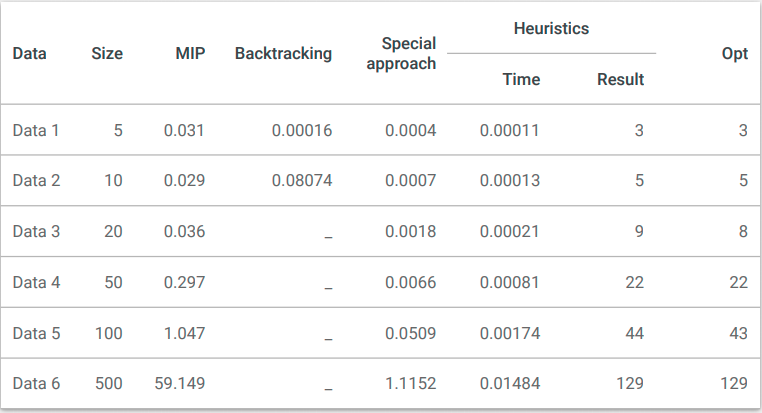

## V. Conclusion
    [Summarize the objective of the work, results obtained..]
    In this report, we presented the mathematical model of the vehicle routing problem, proposed methods for solving it including branch and bound and heuristic methods... The experimental results show that... heuristic method cannot find optimal solutions but it can find good solutions in a reasonable time with very large instances...

In [31]:
import numpy as np
from ortools.linear_solver import pywraplp
import random as rd
from time import time
import sys

sys.setrecursionlimit(1000000000)
FILENAME = "/home/ubuntu/Downloads/data_samples_mini_projects/miniproject-20/data.txt"

## Data generazation

In [32]:
def gen_data(N, M, K):
    infile = open(FILENAME, 'w')

    print(N, M, K, end=' ', file=infile)
    for i in range(N):
        print(file=infile)
        T = rd.randrange(K, M + 1)
        print(T, end=' ', file=infile)
        for j in rd.sample(range(1, M + 1), T):
            print(j, end=' ', file=infile)
    infile.close()

## I/O

In [33]:
def input_from(filename):
    infile = open(filename, 'r')
    
    N, M, K = [int(i) for i in infile.readline().split()]
    
    A = []
    L = np.zeros((N,M), dtype = 'int')
    for i in range(N):
        A.append(sorted([int(k) for k in infile.readline().split()[1:]]))
        if len(A) < K:
            objective_value = "INFEASIBLE"
        for j in A[i]:
            L[i, j - 1] = 1
    infile.close()
    return A, L

def output():
    print(objective_value)
    if objective_value != "INFEASIBLE":
        for i in range(N):
            print()
            for j in range(K):
                print(optimal_solution[i][j], end=' ')

## Different approaches to solve the problem

### OR-tools

In [34]:
def ortools():
    """Minimize the maximal number of articles that a scientist can take on using OR-tools.
    
    solver   solver using Mixed-Integer Programmin with SCIP
    Y        variable mataining the objective function of the SCIP solver    
    """
    global objective_value, optimal_solution
    
    solver = pywraplp.Solver.CreateSolver('SCIP')
    
    INF = solver.infinity()

    X = np.array([[None]*M for i in range(N)])
    Y = solver.IntVar(-INF, INF, 'Y')

    for i in range(N):
        for j in range(M):
            X[i, j] = solver.IntVar(0, int(L[i, j]), 'X[{}, {}]'.format(i, j))

    for i in range(N):
        solver.Add(K == sum(L[i, j]*X[i, j] for j in range(M)))
        
    for j in range(M):
        solver.Add(Y >= sum(L[i, j]*X[i, j] for i in range(N)))

    solver.Minimize(Y)
    status = solver.Solve()
    
    if status == pywraplp.Solver.OPTIMAL:
        objective_value = solver.Objective().Value()
        optimal_solution = [[j + 1 for j in range(M) if X[i, j].solution_value() == 1] for i in range(N)]
    else:
        objective_value = "INFEASIBLE"

#### Source code

### Heuristics

In [35]:
def heuristics():
    """Minimize the maximal number of articles that a scientist can take on using heuristics.
    
    workload            workload[j] will maintains the number of articles that the scientist j is currently taking
    optimal_solution    optimal_solution[i] maintains the scientists that is currenty taking the article i. After execution, it will be optimal
    """
    global objective_value, optimal_solution
    
    if objective_value != "INFEASIBLE":
        workload = [0]*M                                             # workload a scientist is currently taking, initially 0
        optimal_solution = [[] for i in range(N)]
        for i in range(N):                                           # for each article i
            list = sorted([(workload[j - 1], j) for j in A[i]])      # sort all scientists who CAN take the artcile i in the order of inceasing currently-taking workload
            optimal_solution[i] = [_[1] for _ in list[:K]]           # select in that list K scientists who is currently taking smallest workload
            for j in optimal_solution[i]:                            # then increase the workload of
                workload[j - 1] += 1                                 # each of these scientists by 1

        objective_value = max(workload)

### Backtracking

In [36]:
def backtracking():
    """
    Find the t th scientist for the article i.

    index              the INDEX in A[i] of a scientist
    available_range    the range in which index varies. This ensures eliminating repetition.
    workload           workload[j] will maintains the number of articles that the scientist j is currently taking
    solution           a Nx3 nested list maintaining a way of assignment. Note that ...[i][t] indicates INDEX in A[i], not the name of a scientist.
    """
    solution = [[-1]*K for _ in range(N)]
    workload = [0]*M
    
    def Try(i, t):
        global objective_value
        
        available_range = range(solution[i][t - 1] + 1, len(A[i]) - K + t + 1)
        for index in available_range:
            if workload[A[i][index] - 1] + 1  < objective_value:    # branch and bound
                solution[i][t] = index                              # choose a scientist in A[i]
                workload[A[i][index] - 1] += 1                      # increase the workload of that scientist by 1
                if i == N - 1 and t == K - 1: Update()              # if sufficient scientists are chosen, then Update
                else:
                    if t < K - 1: Try(i, t + 1)                     # find scientists for the article i until enough K are chosen
                    else: Try(i + 1, 0)                             # then move to the next article
                workload[A[i][index] - 1] -= 1                      # After completing Try with that scientist, abandons him
                solution[i][t] = -1                                 # in order to try another candidate

    def Update():
        global objective_value, optimal_solution
        if max(workload) < objective_value:                # if the maximal workload of the current solution is the minimal recorded
            objective_value = max(workload)                # then we will save it
            optimal_solution = [[A[i][j] for j in solution[i]] for i in range(N)]
        
    if objective_value != "INFEASIBLE":
        Try(0, 0)

## Execution

In [ ]:
data_sizes = [(5, 4, 2), (10, 7, 3), (20, 15, 6), (50, 35, 15), (100, 70, 30), (300, 210, 90)]

for (N, M, K) in data_sizes:
    gen_data(N, M, K)
    
    for algorithm in ("ortools", "heuristics", "backtracking"):
        print(algorithm)

        A, L = input_from(FILENAME)
        objective_value, optimal_solution = float('inf'), []

        start_time = time()
        eval(algorithm + "()")
        end_time = time()
        
        print(end_time - start_time)
        
        output()

### Another approach

#### Source code

In [37]:
FILENAME = r"C:\Users\Duy Hung\Desktop\data5000.txt"
def get_data(filename):
    """
    Process user's input and generate data.
    
    N    number of articles
    M    number of scientists
    K    minimal number of scientists working on each article
    L    matrix representation of data. L[i, j] = 1 means scientist j can take on article i
    """
    infile = open(filename, 'r')
    
    N, M, K = [int(i) for i in infile.readline().split()]
    
    L = np.zeros((N+1,M+1), dtype = 'int')
    # Create N+1 and M+1 so that get the numbers of scientist and article 
    # The additional collumn M+1 and row N+1 give me information of 
    # the number of scientist take an article and the number of article 
    # taken by a scientist in order by get the sum of each collumn and row

    for i in range(1,N+1):
        a = [int(k) for k in infile.readline().split()][1:]
        for j in a:
            L[i,j] = 1
            L[0,j] += L[i,j]
    for j in range(1,M+1):
        for i in range(1,N+1):
            L[i,0] += L[i,j]
    return N, M, K, L

'''
an arrange function that we can 'easily' reduce the number of article
among 'the_scientist_take_the_max_article'
'''     
def arrange(L):
    L = L[L[:,0].argsort()]
    L = L.T
    L = L[L[:,0].argsort()]
    L = L.T
    return L
def predecessor(L):
    #find the predecessor of max(article taken by the scientist)
    i = 0
    while max(L) - L[len(L)-1-i] == 0 and i != len(L) :
        i += 1
    return [L[len(L)-1-i],i]

'''
    Stop condition for this algorithm:
    - if all the number of scientists take an article = K(the minimum scientist need to take each article)
    - if we can't reduce the_max_number of article taken by a scientist
    any more OR the_max_number after reduce is not equal to the
    predecessor(of max).
    #Note
        #trong qua trinh tru thi se co hang bang K.
        #nhung nhung hang o duoi thi co hang > K
        #tao dieu kien dung(tai mot hang) khi ma ta
        #tru den gia tri toi thieu(o day la K) 
        => stopCDT()
'''
def stopCDT(L,K):
    address = np.where(L[:,0][1:] == K)[0]
    if address.size > 0:
        return max(address)
    else:
        return 0
def solver(L,N,M,K):
    L = arrange(L)
    global check
    p = predecessor(L[0][1:])
    t = 0  
    i = 0
    t1 = float('inf')
    st = stopCDT(L, K) 
    if L[N,0] == K:
        check = False    
    else:
        if p[0] != max(L[0]): #this sequence has predecessor
            for j in range(p[1]): #interate till find the predecessor
                while (L[0,M-j] != p[0]): #check when to stop reduce
                    if N-i == st:
                        break    
                    if (L[N-i,0]!= K) :    
                        if L[N-i,M-j] == 1:   
                            L[N-i,M-j] = 0
                            L[0,M-j] -= 1
                            L[N-i,0] -= 1
                            t += 1  #check if we can reduce the_max_article_taken by a scientist 
                                    #equal to predecessor
                                    #if not, break and then solution = max(after reduce)
                            if st != 0 and st != N:#update stop
                                k = st 
                                while (L[k,0] == K) and k!=N: 
                                    k+=1
                                st = k                            
                    i += 1
                if t1 > t:
                    t1 = t
                i = 0
                t = 0
            if t1 == 0:
                check = False
            elif (t1 < max(L[0]) - predecessor(L[0])[0]):
                return L
                check = False
        else:   # this sequence has no predecessor
            for j in range(p[1]):
                while N-i != st:
                    if L[N-i,0] != K:
                        if L[N-i,M-j] == 1:   
                            L[N-i,M-j] = 0
                            L[0,M-j] -= 1
                            L[N-i,0] -= 1
                            t += 1
                            if st != 0 and st != N:#update stop
                                k = st 
                                while (L[k,0] == K) and k!=N: 
                                    k+=1
                                st = k   
                        break
                    i += 1
                if t1 > t:
                    t1 = t
                t = 0
                i = 0
            if t1 == 0:
                return L
                check = False
    return L
def printmt(L,N,M):
    a = []
    for i in range(1,N+1):
        for j in range(1,M+1):
            if L[i,j] != 0:
                a.append(j)
        print(a)
        a = []

check = True
def special_algorithm():
    N, M, K, L = get_data(FILENAME) 
    while check:
        L = solver(L,N,M,K)
    print(L)
    printmt(L,N,M)
    print('solution is: ', max(L[0]))

special_algorithm()